In [20]:
import time
import os
import cv2
import matplotlib.pyplot as plt
from lib.utilities import *
import numpy as np
import pandas as pd
import datetime

In [2]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/"
cell_type_prefix = 'scnn1a'
plt.rcParams.update({'font.size': 13})
#plt.rcParams['figure.figsize'] = [20, 12]

In [23]:
# work with latency data
# Load data, not from Drive for Desktop since PhotoZ complains about loading zda from Drive
csv_prefix = cell_type_prefix + '_all_slices.csv'
csv_columns = ['Date',
             'Slice/Loc/Rec',
             'Slice Location',
             'Stim Location',
             'L4 barrel 1 Latency',
             'L4 barrel 2 Latency',
             'L4 barrel 3 Latency',
             'L4 barrel 1 SNR',
             'L4 barrel 2 SNR',
             'L4 barrel 3 SNR',
             'ROI jpg',
              'Age',
              'Infusion',
              'Sex',
              'Stim (uA)',
              'Delta latency 1 (barrel 1 - barrel 2)',
              'Delta latency 2 (barrel 3 - barrel 2)']

# Load reference data for all slices
reference_file = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/" + cell_type_prefix + "_catalog.csv"
reference_df = pd.read_csv(reference_file)
ref_cols = ['Age', 
          'Sex', 
          "Infusion", 
          'Stim (uA)']

# load the all-data CSV dir
df = pd.read_csv(data_dir + csv_prefix)
df = pd.DataFrame(df)
df

,Date,Slice/Loc/Rec,Slice Location,Stim Location,L4 barrel 1 Latency,L4 barrel 2 Latency,L4 barrel 3 Latency,L4 barrel 1 SNR,L4 barrel 2 SNR,L4 barrel 3 SNR,ROI jpg,Age,Infusion,Sex,Stim (uA),Delta latency 1 (barrel 1 - barrel 2),Delta latency 2 (barrel 3 - barrel 2),abs(delta 1),abs(delta 2)
0,2/28/2023,02_01_01,NaN,L5,50.3009,50.8406,49.3457,2.940390,10.630900,6.484390,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,58,NaN,M,100,NaN,-1.4949,NaN,1.4949
1,2/28/2023,02_02_02,NaN,L5,49.9882,51.3212,51.1805,2.045210,5.142090,2.921330,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,58,NaN,M,100,NaN,NaN,NaN,NaN
2,2/28/2023,03_01_01,NaN,L2/3,52.5719,51.2136,52.9013,9.405090,10.237200,5.780930,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,58,NaN,M,100,1.3583,1.6877,1.3583,1.6877
3,2/28/2023,03_02_02,NaN,L2/3,51.8399,50.0310,50.7536,14.738200,35.400200,21.883200,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,58,NaN,M,100,1.8089,0.7226,1.8089,0.7226
4,2/28/2023,06_01_01,NaN,L5,51.1367,51.0128,50.4326,5.726470,13.058300,13.063500,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,58,NaN,M,100,0.1239,-0.5802,0.1239,0.5802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,6/28/2023,02_04_03,Posterior,L4,58.3278,94.0000,94.0000,1.284740,0.000000,0.000000,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,83,GABAzine,F,200,NaN,NaN,NaN,NaN
86,6/28/2023,03_01_10,Posterior,L4,94.0000,51.1749,51.3676,0.000000,0.263371,1.110580,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,83,GABAzine,F,200,NaN,NaN,NaN,NaN
87,6/28/2023,03_02_03,Posterior,L4,58.9868,58.3472,94.0000,0.077615,0.514122,0.000000,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,83,GABAzine,F,200,NaN,NaN,NaN,NaN
88,6/28/2023,03_03_01,Posterior,L4,50.7398,94.0000,94.0000,0.862532,0.000000,0.000000,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,83,GABAzine,F,200,NaN,NaN,NaN,NaN


In [36]:
# Repeat analysis (originally done in ROI-to-CSVdata.ipynb) but split by Rostral / caudal 
data = {}
snr_cutoff_signal = 5.0
for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    data[stim_loc] = {}
    
    for slice_loc in ['Anterior', 'Posterior']:
        df2_sl = df2[df2['Slice Location'] == slice_loc]
        
        data[stim_loc][slice_loc] = {}

        print(slice_loc + " barrel pairs in", stim_loc)
        # count number of barrel pairs with no signal crossing
        n_barrel_no_cross = len(df2_sl[(df2_sl['L4 barrel 1 SNR'] < snr_cutoff_signal) & 
                                   (df2_sl['L4 barrel 2 SNR'] > snr_cutoff_signal)])
        n_barrel_no_cross += len(df2_sl[(df2_sl['L4 barrel 2 SNR'] < snr_cutoff_signal) & 
                                    (df2_sl['L4 barrel 1 SNR'] > snr_cutoff_signal)])
        n_barrel_no_cross += len(df2_sl[(df2_sl['L4 barrel 2 SNR'] < snr_cutoff_signal) & 
                                    (df2_sl['L4 barrel 3 SNR'] > snr_cutoff_signal)])
        n_barrel_no_cross += len(df2_sl[(df2_sl['L4 barrel 3 SNR'] < snr_cutoff_signal) & 
                                    (df2_sl['L4 barrel 2 SNR'] > snr_cutoff_signal)])
        print("\t", n_barrel_no_cross, "no crossing out of", len(df2_sl) * 2, "in layer", stim_loc)

        # count number of barrel pairs with signal crossing
        n_barrel_cross = len(df2_sl[(df2_sl['L4 barrel 1 SNR'] > snr_cutoff_signal) & 
                                (df2_sl['L4 barrel 2 SNR'] > snr_cutoff_signal)])
        n_barrel_cross += len(df2_sl[(df2_sl['L4 barrel 2 SNR'] > snr_cutoff_signal) & 
                                 (df2_sl['L4 barrel 3 SNR'] > snr_cutoff_signal)])
        print("\t", n_barrel_cross, "crossing out of", len(df2_sl) * 2, "in layer", stim_loc)

        # count number of barrel pairs with no signal
        n_barrel_none = len(df2_sl[(df2_sl['L4 barrel 1 SNR'] < snr_cutoff_signal) & 
                                (df2_sl['L4 barrel 2 SNR'] < snr_cutoff_signal)])
        n_barrel_none += len(df2_sl[(df2_sl['L4 barrel 2 SNR'] < snr_cutoff_signal) & 
                                 (df2_sl['L4 barrel 3 SNR'] < snr_cutoff_signal)])
        print("\t", n_barrel_none, "no signal out of", len(df2_sl) * 2, "in layer", stim_loc)
        
        data[stim_loc][slice_loc]['n_barrel_no_cross'] = n_barrel_no_cross
        data[stim_loc][slice_loc]['n_barrel_cross'] = n_barrel_cross
        data[stim_loc][slice_loc]['n_barrel_none'] = n_barrel_none
        data[stim_loc][slice_loc]['total'] = len(df2_sl) * 2 - n_barrel_none


Anterior barrel pairs in L2/3
	 3 no crossing out of 28 in layer L2/3
	 2 crossing out of 28 in layer L2/3
	 23 no signal out of 28 in layer L2/3
Posterior barrel pairs in L2/3
	 7 no crossing out of 20 in layer L2/3
	 3 crossing out of 20 in layer L2/3
	 10 no signal out of 20 in layer L2/3
Anterior barrel pairs in L4
	 6 no crossing out of 22 in layer L4
	 2 crossing out of 22 in layer L4
	 14 no signal out of 22 in layer L4
Posterior barrel pairs in L4
	 8 no crossing out of 36 in layer L4
	 5 crossing out of 36 in layer L4
	 23 no signal out of 36 in layer L4
Anterior barrel pairs in L5
	 0 no crossing out of 0 in layer L5
	 0 crossing out of 0 in layer L5
	 0 no signal out of 0 in layer L5
Posterior barrel pairs in L5
	 5 no crossing out of 6 in layer L5
	 0 crossing out of 6 in layer L5
	 1 no signal out of 6 in layer L5


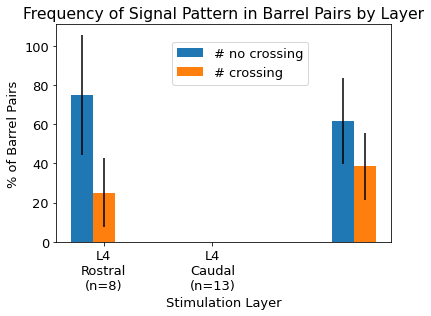

In [58]:
plt.clf()
i = 0
length_of_previous_sl = 0
tick_labels = []
colors = {"# no crossing": 'tab:blue', "# crossing": 'tab:orange'}
# in format # no crossing, # crossing, # no signal; l2/3, L4, L5
for sl in ['Anterior', 'Posterior']:
    
    length_of_previous_sl = i
    
    n_L23 = data['L2/3'][sl]['total']
    n_L4 = data['L4'][sl]['total']
    n_L5 = data['L5'][sl]['total']
    
    all_layers = []
    totals = []
    if n_L23 > 0:
        pass
        #all_layers.append('L2/3')
        #totals.append(n_L23)
    if n_L4 > 0:
        all_layers.append('L4')
        totals.append(n_L4)
    if n_L5 > 0:
        pass
        #all_layers.append('L5')
        #totals.append(n_L5)
    
    
    # in columns L23, L4, L5
    crossing_data = {
        "# no crossing": [data[x][sl]['n_barrel_no_cross'] for x in all_layers],
        '# crossing': [data[x][sl]['n_barrel_cross'] for x in all_layers],
        #'# no signal': [data[x][sl]['n_barrel_none'] for x in ['L2/3', 'L4', 'L5']],
        #"L2/3": [3, 17, 30],
        #"L4": [38, 20, 30],
        #"L5": [8, 13, 1]
    }
    errbars = {}
    for k in crossing_data:
        errbars[k] = [np.sqrt(x) for x in crossing_data[k]]
        for j in range(len(totals)):
            crossing_data[k][j] /= totals[j] / 100
            errbars[k][j] /= totals[j] / 100
            
    labels = [x for x in crossing_data.keys()]
    tick_labels += [all_layers[j] + "\n" + ("Rostral" if sl == "Anterior" else "Caudal") + "\n(n="+str(totals[j]) + ")"
                                for j in range(len(all_layers))]

    # plot this as bars 
    for nm in crossing_data:
        x = np.arange(length_of_previous_sl, len(all_layers) + length_of_previous_sl)
        '''        if i == length_of_previous_sl + 1:  # first iter of this sl
            plt.bar(x + (i-1) * 0.2, 
                    crossing_data[nm],
                    0.2,
                    label=nm,
                    tick_label=tick_labels)
                                #'L2/3\n(n='+str(n_L23)+')', 
                                #'L4\n(n='+str(n_L4)+')', 
                                #'L5\n(n='+str(n_L5)+')'])'''
        # else:
        plt.bar(x + (i-1) * 0.2, 
            crossing_data[nm],
            0.2,
            label=(nm if length_of_previous_sl == 0 else None),
            color=colors[nm])
        plt.errorbar(x + (i-1) * 0.2, 
                    crossing_data[nm],
                    yerr=errbars[nm],
                    fmt='none',
                    color='black')
        i += 1
    
plt.title("Frequency of Signal Pattern in Barrel Pairs by Layer")
plt.xlabel("Stimulation Layer")
plt.ylabel("% of Barrel Pairs")
plt.xticks(np.arange(len(tick_labels)), tick_labels)
#plt.xticks(rotation='vertical')
plt.legend(bbox_to_anchor=(0.55, .95), loc='upper center')
plt.savefig(data_dir + "results_count_prelim_" + str(datetime.date.today()) + ".png", bbox_inches="tight")
plt.show()

Latency between anterior (rostral) barrel pairs in L2/3
	 0.384 +/- 0.369 (n = 2)
	 [0.0147 0.7534]
Latency between posterior (caudal) barrel pairs in L2/3
	 0.344 +/- 0.076 (n = 3)
	 [0.2455 0.433  0.3538]
Latency between anterior (rostral) barrel pairs in L4
	 1.630 +/- 0.417 (n = 2)
	 [1.2135 2.048 ]
Latency between posterior (caudal) barrel pairs in L4
	 0.476 +/- 0.234 (n = 6)
	 [0.4992 0.8238 0.1898 0.4909 0.6745 0.1808]


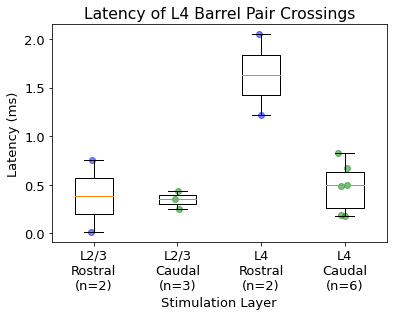

In [52]:
# plot latency spreads, separated by layer

df['abs(delta 1)'] = np.abs(df['Delta latency 1 (barrel 1 - barrel 2)'])
df['abs(delta 2)'] = np.abs(df['Delta latency 2 (barrel 3 - barrel 2)'])


plt.clf()
i = 1
xtick_labels = []
df_datasets = []
for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    
    df2_ant = df2[df2['Slice Location'] == "Anterior"]
    dfd1_ant = df2_ant['abs(delta 1)'].dropna()
    dfd2_ant = df2_ant['abs(delta 2)'].dropna()
    
    df2_post = df2[df2['Slice Location'] == "Posterior"]
    dfd1_post = df2_post['abs(delta 1)'].dropna()
    dfd2_post = df2_post['abs(delta 2)'].dropna()
    
    dfds_ant = np.concatenate([dfd1_ant, dfd2_ant])
    dfds_post = np.concatenate([dfd1_post, dfd2_post])
    
    if len(dfds_ant) > 0:
        print("Latency between anterior (rostral) barrel pairs in", stim_loc)
        print("\t", 
              str(np.mean(dfds_ant))[:5], 
              "+/-", 
              str(np.std(dfds_ant))[:5], 
              "(n =", 
              str(len(dfds_ant)) + ")")
        print("\t", dfds_ant)
    if len(dfds_post) > 0:
        print("Latency between posterior (caudal) barrel pairs in", stim_loc)
        print("\t", 
              str(np.mean(dfds_post))[:5], 
              "+/-", 
              str(np.std(dfds_post))[:5], 
              "(n =", 
              str(len(dfds_post)) + ")")
        print("\t", dfds_post)
    if len(dfds_post) < 1 and len(dfds_ant) < 1:
        continue
    
    jittered_xs_1 = np.random.normal(i, 0.04, dfds_ant.shape[0])
    jittered_xs_2 = np.random.normal(i+1, 0.04, dfds_post.shape[0])
    plt.scatter(jittered_xs_1, dfds_ant, alpha=0.5, color='blue')
    plt.scatter(jittered_xs_2, dfds_post, alpha=0.5, color='green')

    xtick_labels.append(stim_loc + "\nRostral\n(n=" + str(len(dfds_ant)) +")")
    xtick_labels.append(stim_loc + "\nCaudal\n(n=" + str(len(dfds_post)) +")")
    df_datasets.append(dfds_ant)
    df_datasets.append(dfds_post)
    i += 2

plt.boxplot(df_datasets)
plt.xticks(range(1, len(xtick_labels)+1), xtick_labels)
plt.title("Latency of L4 Barrel Pair Crossings")
plt.xlabel("Stimulation Layer")
plt.ylabel("Latency (ms)")
plt.savefig(data_dir + cell_type_prefix + "_results_latency_prelim_" + str(datetime.date.today()) +".png", bbox_inches="tight")
plt.show()

     Index     Cell 1     Cell 2     Cell 3
0        0  11.465200  15.436400  11.959000
1        1  10.643300  14.161100  11.154400
2        2   9.257740  12.330300   9.668380
3        3   7.476610  10.021500   7.665680
4        4   5.780280   7.693800   5.675050
..     ...        ...        ...        ...
195    195   0.783194   0.808717   0.887737
196    196   0.874195   1.305960   0.800768
197    197   0.787404   1.790920   0.507184
198    198   0.695885   2.293020   0.111556
199    199   0.806976   2.752740  -0.187036

[200 rows x 4 columns]


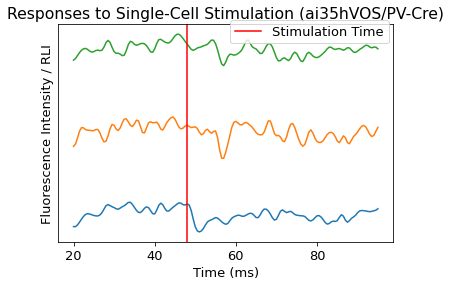

In [21]:
# 6/30 single cell stim traces
traces_barrel_1 = data_dir + "06-30-23/selected_zda/Traces_03_02_04.dat"
traces_barrel_1 = pd.read_csv(traces_barrel_1,
                         sep='\t',
                         header=0,
                         names=['Index',  'Cell 1',  'Cell 2',  'Cell 3'])
print(traces_barrel_1)
plt.clf()
start_cut = 40
end_cut = 190
baseline = 10
v1 = traces_barrel_1.loc[start_cut:end_cut, ["Cell 1"]] + baseline
v2 = traces_barrel_1.loc[start_cut:end_cut, ["Cell 2"]] + baseline * 2
v3 = traces_barrel_1.loc[start_cut:end_cut, ["Cell 3"]] + baseline * 3
t = [(i+start_cut) * 0.5 for i in range(len(v1))]
plt.plot(t, v1)
plt.plot(t, v2)
plt.plot(t, v3)
plt.axvline(x=48, label="Stimulation Time", color='red')
plt.legend(bbox_to_anchor=(0.75, 1.05), loc='upper center')
plt.yticks([])
plt.xlabel("Time (ms)")
plt.ylabel("Fluorescence Intensity / RLI")
plt.title("Responses to Single-Cell Stimulation (ai35hVOS/" + cell_type_prefix + "-Cre)")
plt.savefig(data_dir + "06-30-23/selected_zda/" + cell_type_prefix + "_traces-single-cell.png")
plt.show()